In [118]:
import os
import glob
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, classification_report,recall_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve,f1_score,
    average_precision_score,ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
from xgboost import XGBClassifier



In [119]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

In [120]:
class IMUClassifier:
    def __init__(self, data_dir="data", out_dir="out"):
        self.data_dir = data_dir
        self.train_dir = os.path.join(data_dir, "train")  
        os.makedirs(out_dir, exist_ok=True)
        self.out_dir = out_dir

        self.channels = ["Roll", "Gyroscope_z", "Gravity_x",
                         "Rot12", "Rot13", "Rot21", "Rot22", 
                         "Rot23", "Rot31", "Rot32", "Rot33","Gravity.y", "Gravity.z",
                         "Accelerometer.x", "Accelerometer.y", "Accelerometer.z",
                         "Gyroscope.x", "Gyroscope.y",
                         "Magnetometer.x", "Magnetometer.y", "Magnetometer.z"]
        self.feature_columns = []

        self.train_files = None
        self.val_files = None
        self.test_files = None

        self.X_train = self.y_train = None
        self.X_val = self.y_val = None
        self.X_test = self.y_test = None

        self.scaler = None
        self.model = None

    def _list_csvs(self, folder):
        files = []
        if os.path.isdir(folder):
            for lab in ("left","right"):
                for p in sorted(glob.glob(os.path.join(folder, lab, "*.csv"))):
                    label = 0 if lab == "left" else 1
                    files.append((p, label))
        return files

    def load_data(self, val_ratio=0.15, test_ratio=0.15, random_state=42):
        """
        Simple split of all CSVs found under self.train_dir (left/right) into
        train / validation / test using stratified splitting.
            """
        all_files = self._list_csvs(self.train_dir)
        if not all_files:
            raise RuntimeError(f"No files found in {self.train_dir}")
    
        paths = np.array([p for p, _ in all_files])
        labels = np.array([lbl for _, lbl in all_files])
    
        rest_frac = val_ratio + test_ratio
        if rest_frac <= 0:
            # everything goes to training
            train_idx = np.arange(len(paths))
            val_idx = np.array([], dtype=int)
            test_idx = np.array([], dtype=int)
        else:
            # decide whether stratify is safe (at least 2 samples per class)
            class_counts = np.bincount(labels)
            safe_stratify = (len(class_counts) == 2) and (class_counts.min() >= 2)
    
            # first split: train vs (val+test)
            train_idx, temp_idx = train_test_split(
                np.arange(len(paths)),
                test_size=rest_frac,
                stratify=labels if safe_stratify else None,
                random_state=random_state,
                shuffle=True
            )
    
            # second split: temp -> val and test
            if len(temp_idx) == 0:
                val_idx = np.array([], dtype=int)
                test_idx = np.array([], dtype=int)
            else:
                rel_val = val_ratio / rest_frac  # fraction of the temp chunk that becomes validation
                val_rel_idx, test_rel_idx = train_test_split(
                    np.arange(len(temp_idx)),
                    test_size=1.0 - rel_val,
                    stratify=labels[temp_idx] if safe_stratify else None,
                    random_state=random_state,
                    shuffle=True
                )
                val_idx = temp_idx[val_rel_idx]
                test_idx = temp_idx[test_rel_idx]
    
        self.train_files = [(paths[i], int(labels[i])) for i in train_idx]
        self.val_files   = [(paths[i], int(labels[i])) for i in val_idx]
        self.test_files  = [(paths[i], int(labels[i])) for i in test_idx]
    
        print(f"Loaded and split data: total={len(all_files)}, train={len(self.train_files)}, val={len(self.val_files)}, test={len(self.test_files)}")

    # ---------- feature extraction ----------
    def _extract_basic_features(self, df):
        feats = {}
        n = len(df)
        for ch in self.channels:
            if ch in df.columns:
                arr = pd.to_numeric(df[ch], errors="coerce").ffill().bfill().fillna(0).values
            else:
                arr = np.zeros(n, dtype=float)
            feats[f"{ch}_mean"] = float(np.mean(arr))
            feats[f"{ch}_std"]  = float(np.std(arr))
            feats[f"{ch}_min"]  = float(np.min(arr))
            feats[f"{ch}_max"]  = float(np.max(arr))
        feats["duration"] = float(n)
        return feats

    def _build_feature_table(self, file_label_list):
        rows, labels, paths = [], [], []
        for path,label in file_label_list:
            df = pd.read_csv(path)
            feats = self._extract_basic_features(df)
            rows.append(feats)
            labels.append(label)
            paths.append(path)
        if len(rows)==0:
            return pd.DataFrame(), np.array([], dtype=int)
        feat_df = pd.DataFrame(rows).fillna(0.0)
        feat_df["label"] = np.array(labels, dtype=int)
        feat_df["path"] = paths
        return feat_df, np.array(labels, dtype=int)

    # ---------- transform & save features ----------
    def transform_data(self):
        train_df, y_train = self._build_feature_table(self.train_files)
        val_df, y_val = self._build_feature_table(self.val_files)
        test_df, y_test = self._build_feature_table(self.test_files)

        if train_df.empty:
            raise RuntimeError("No training data found.")

        # choose and save feature columns
        self.feature_columns = [c for c in train_df.columns if c not in ("label","path")]
        
        # Save feature CSVs
        train_df.to_csv(os.path.join(self.out_dir, "features_train.csv"), index=False)
        val_df.to_csv(os.path.join(self.out_dir, "features_val.csv"), index=False)
        test_df.to_csv(os.path.join(self.out_dir, "features_test.csv"), index=False)
        print("Saved features CSVs to out_dir")

        # build numpy arrays
        X_train = train_df[self.feature_columns].values.astype(float)
        X_val = val_df[self.feature_columns].values.astype(float) if not val_df.empty else np.empty((0, len(self.feature_columns)))
        X_test = test_df[self.feature_columns].values.astype(float) if not test_df.empty else np.empty((0, len(self.feature_columns)))

        # fit scaler on training only and save
        self.scaler = StandardScaler()
        X_train_s = self.scaler.fit_transform(X_train)
        joblib.dump(self.scaler, os.path.join(self.out_dir, "scaler.joblib"))

        X_val_s = self.scaler.transform(X_val) if X_val.shape[0] > 0 else X_val
        X_test_s = self.scaler.transform(X_test) if X_test.shape[0] > 0 else X_test

        self.X_train, self.y_train = X_train_s, y_train
        self.X_val, self.y_val = X_val_s, y_val
        self.X_test, self.y_test = X_test_s, y_test

        # produce a PCA 2D scatter and save
        try:
            pca = PCA(n_components=2)
            proj = pca.fit_transform(np.vstack([X_train_s, X_val_s]) if X_val_s.size>0 else X_train_s)
            labels_for_plot = np.concatenate([y_train, y_val]) if X_val_s.size>0 else y_train
            plt.figure(figsize=(6,5))
            plt.scatter(proj[:,0], proj[:,1], c=labels_for_plot, cmap="Set1", s=40, edgecolor="k", alpha=0.8)
            plt.title("PCA (train [+val])")
            plt.xlabel("PC1"); plt.ylabel("PC2")
            plt.savefig(os.path.join(self.out_dir, "pca_train_val.png"), dpi=150, bbox_inches="tight")
            plt.close()
        except Exception as e:
            print("PCA plot failed:", e)

        print("Transformed data and saved scaler.")

    # ---------- model ----------
    def load_model(self, prefit=None):
        if prefit is None:
            # self.model = DecisionTreeClassifier(min_samples_leaf=5, max_depth = 4)
            # self.model = DecisionTreeClassifier()
            # self.model = RandomForestClassifier(n_estimators=10,min_samples_leaf=5, max_depth = 4)
            self.model = XGBClassifier(
                    n_estimators=100,
                    learning_rate=0.1,
                    max_depth=4,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    eval_metric="logloss",
                    use_label_encoder=False
                )
        else:
            
            self.model = prefit

    def train_model(self, cv_folds=5):
        if self.model is None:
            self.load_model()
        if self.X_train is None:
            raise RuntimeError("Call transform_data() first.")

        cv_scores = None

        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=0)
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=cv, scoring="accuracy", n_jobs=-1)
        cv_path = os.path.join(self.out_dir, "training_cv_scores.csv")
        pd.DataFrame({"cv_fold_idx": np.arange(len(cv_scores)), "accuracy": cv_scores}).to_csv(cv_path, index=False)
        print("Saved CV scores:", cv_path)

        # fit on full training set
        self.model.fit(self.X_train, self.y_train)
        joblib.dump(self.model, os.path.join(self.out_dir, "model.joblib"))
        print("Model trained and saved.")

        if cv_scores is not None:
            print("Train CV acc mean/std:", cv_scores.mean(), cv_scores.std())

    # ---------- evaluation & saving metrics/plots ----------
    def test_model(self):
        if self.model is None:
            raise RuntimeError("Train or load model first.")
        results = {}

        # evaluate on validation
        if self.X_val is not None and self.X_val.shape[0] > 0:
            yv_pred = self.model.predict(self.X_val)
            yv_proba = self.model.predict_proba(self.X_val)[:,1] if hasattr(self.model, "predict_proba") else None
            results["validation_accuracy"] = float(accuracy_score(self.y_val, yv_pred))
            results["validation_precision"] = float(precision_score(self.y_val, yv_pred))
            results["validation_report"] = classification_report(self.y_val, yv_pred, target_names=["left","right"])
            cm = confusion_matrix(self.y_val, yv_pred)
            results["validation_confusion_matrix"] = cm.tolist()
            # save confusion image
            self._save_confusion_matrix(cm, ["left","right"], os.path.join(self.out_dir, "confusion_val.png"))
            # ROC / PR for validation
            if yv_proba is not None:
                self._save_roc_pr(self.y_val, yv_proba, "validation", self.out_dir)
        else:
            results["validation_accuracy"] = None

        # evaluate on test
        if self.X_test is not None and self.X_test.shape[0] > 0:
            yt_pred = self.model.predict(self.X_test)
            yt_proba = self.model.predict_proba(self.X_test)[:,1] if hasattr(self.model, "predict_proba") else None
            results["test_accuracy"] = float(accuracy_score(self.y_test, yt_pred))
            results["test_precision"] = float(precision_score(self.y_test, yt_pred))
            results["test_report"] = classification_report(self.y_test, yt_pred, target_names=["left","right"])
            cm = confusion_matrix(self.y_test, yt_pred)
            results["test_confusion_matrix"] = cm.tolist()
            self._save_confusion_matrix(cm, ["left","right"], os.path.join(self.out_dir, "confusion_test.png"))
            if yt_proba is not None:
                self._save_roc_pr(self.y_test, yt_proba, "test", self.out_dir)
        else:
            results["test_accuracy"] = None

        # training accuracy
        ytr_pred = self.model.predict(self.X_train)
        results["train_accuracy"] = float(accuracy_score(self.y_train, ytr_pred))
        results["train_precision"] = float(precision_score(self.y_train, ytr_pred))

        # save feature importances if available
        if hasattr(self.model, "feature_importances_"):
            try:
                fi = self.model.feature_importances_
                #self._save_feature_importances(fi, self.feature_columns, os.path.join(self.out_dir, "feature_importances.png"))
                self._save_feature_importances(self,fi,self.feature_columns,os.path.join(self.out_dir, "feature_importances.png"))
                
                results["feature_importances"] = {n: float(v) for n,v in zip(self.feature_columns, fi)}
                print("Saving feature importances success:")
            except Exception as e:
                print("Saving feature importances failed:", e)

        with open(os.path.join(self.out_dir, "evaluation_summary.json"), "w") as f:
            json.dump(results, f, indent=2)
        print("Saved evaluation summary and plots to out_dir.")
        return results

    def _save_confusion_matrix(self, cm, labels, outpath):
        try:
            fig, ax = plt.subplots(figsize=(4,4))
            im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
            ax.set_xticks(np.arange(len(labels))); ax.set_yticks(np.arange(len(labels)))
            ax.set_xticklabels(labels); ax.set_yticklabels(labels)
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="black")
            ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion matrix")
            fig.colorbar(im, ax=ax)
            fig.tight_layout()
            fig.savefig(outpath, dpi=150, bbox_inches="tight")
            plt.close(fig)
        except Exception as e:
            print("Confusion matrix save failed:", e)

    def _save_roc_pr(self, y_true, y_proba, prefix, out_dir):
        try:
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(5,4))
            plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
            plt.plot([0,1],[0,1],"--", color="gray")
            plt.title(f"ROC ({prefix})"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
            plt.savefig(os.path.join(out_dir, f"roc_{prefix}.png"), dpi=150, bbox_inches="tight")
            plt.close()

            precision, recall, _ = precision_recall_curve(y_true, y_proba)
            ap = average_precision_score(y_true, y_proba)
            plt.figure(figsize=(5,4))
            plt.plot(recall, precision, label=f"AP={ap:.3f}")
            plt.title(f"Precision-Recall ({prefix})"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
            plt.savefig(os.path.join(out_dir, f"pr_{prefix}.png"), dpi=150, bbox_inches="tight")
            plt.close()
        except Exception as e:
            print("ROC/PR save failed:", e)

    @staticmethod
    def _save_feature_importances(self, importances, feat_names, outpath):
        try:
            idx = np.argsort(importances)[::-1]
            top_n = min(20, len(importances))
            plt.figure(figsize=(8,4))
            plt.bar(range(top_n), importances[idx][:top_n])
            plt.xticks(range(top_n), np.array(feat_names)[idx][:top_n], rotation=45, ha="right")
            plt.title("Feature importances (top {})".format(top_n))
            plt.tight_layout()
            plt.savefig(outpath, dpi=150, bbox_inches="tight")
            plt.close()
        except Exception as e:
            print("Feature importance save failed:", e)

    def inference(self, csv_path):
        if self.scaler is None:
            self.scaler = joblib.load(os.path.join(self.out_dir, "scaler.joblib"))
        if self.model is None:
            self.model = joblib.load(os.path.join(self.out_dir, "model.joblib"))
        df = pd.read_csv(csv_path)
        feats = self._extract_basic_features(df)
        X_row = np.asarray([feats[c] for c in self.feature_columns]).reshape(1, -1)
        Xs = self.scaler.transform(X_row)
        pred = int(self.model.predict(Xs)[0])
        proba = float(self.model.predict_proba(Xs)[0,1]) if hasattr(self.model, "predict_proba") else float(pred)
        label = "right" if pred == 1 else "left"
        return label, proba

    def quick_run_all(self):
        self.load_data()
        self.transform_data()
        self.load_model()
        self.train_model()
        return self.test_model()


In [121]:
clf = IMUClassifier(data_dir="data", out_dir="out")

In [122]:
clf.quick_run_all()

Loaded and split data: total=332, train=232, val=50, test=50
Saved features CSVs to out_dir
Transformed data and saved scaler.
Saved CV scores: out\training_cv_scores.csv
Model trained and saved.
Train CV acc mean/std: 0.9613320999074931 0.03654269948048925


C:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:00:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saving feature importances success:
Saved evaluation summary and plots to out_dir.


{'validation_accuracy': 0.96,
 'validation_precision': 0.9259259259259259,
 'validation_report': '              precision    recall  f1-score   support\n\n        left       1.00      0.92      0.96        25\n       right       0.93      1.00      0.96        25\n\n    accuracy                           0.96        50\n   macro avg       0.96      0.96      0.96        50\nweighted avg       0.96      0.96      0.96        50\n',
 'validation_confusion_matrix': [[23, 2], [0, 25]],
 'test_accuracy': 0.96,
 'test_precision': 1.0,
 'test_report': '              precision    recall  f1-score   support\n\n        left       0.93      1.00      0.96        25\n       right       1.00      0.92      0.96        25\n\n    accuracy                           0.96        50\n   macro avg       0.96      0.96      0.96        50\nweighted avg       0.96      0.96      0.96        50\n',
 'test_confusion_matrix': [[25, 0], [2, 23]],
 'train_accuracy': 1.0,
 'train_precision': 1.0,
 'feature_import

# Second Day test on a newly collected data


--- Inference Metrics ---
Accuracy : 0.917
Precision: 0.833
Recall   : 1.000
F1-score : 0.909


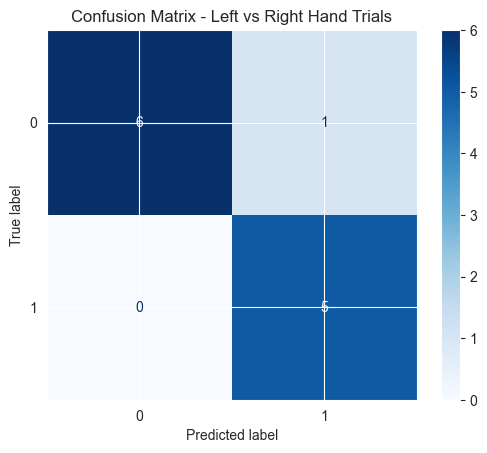

OSError: Cannot save file into a non-existent directory: 'out\test'

In [123]:
MODEL_DIR = "out/test"
DATA_DIR = "data/izhar"
LEFT_DIR = os.path.join(DATA_DIR, "left")
RIGHT_DIR = os.path.join(DATA_DIR, "right")


def run_inference_on_folder(folder_path, label):
    preds, labels = [], []
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            csv_path = os.path.join(folder_path, file)
            pred_label, _ = clf.inference(csv_path)  # unpack tuple
            preds.append(pred_label)
            labels.append(label)
    return preds, labels


# ------------------ RUN INFERENCE ------------------
left_preds, left_labels = run_inference_on_folder(LEFT_DIR, 0)
right_preds, right_labels = run_inference_on_folder(RIGHT_DIR, 1)

pred_map = {"left": 0, "right": 1}

# Combine
y_true = np.array(left_labels + right_labels)
y_pred = np.array([pred_map[p] for p in left_preds + right_preds])

# ------------------ METRICS ------------------
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, pos_label=1)
rec = recall_score(y_true, y_pred, pos_label=1)
f1 = f1_score(y_true, y_pred, pos_label=1)

print("\n--- Inference Metrics ---")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
# 
#  ------------------ CONFUSION MATRIX ------------------
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Left vs Right Hand Trials")
plt.show()

# ------------------ SAVE RESULTS ------------------
results_df = pd.DataFrame({
    "true_label": y_true,
    "predicted_label": y_pred
})
results_df.to_csv(os.path.join(MODEL_DIR, "inference_results.csv"), index=False)
print(f"\nResults saved to: {MODEL_DIR}/inference_results.csv")


# Viz for Importance Feature Relationship and PCA analysis

In [125]:
import pandas as pd

train = pd.read_csv("out/features_train.csv")
feature_cols = [c for c in train.columns if c not in ("label", "path")]


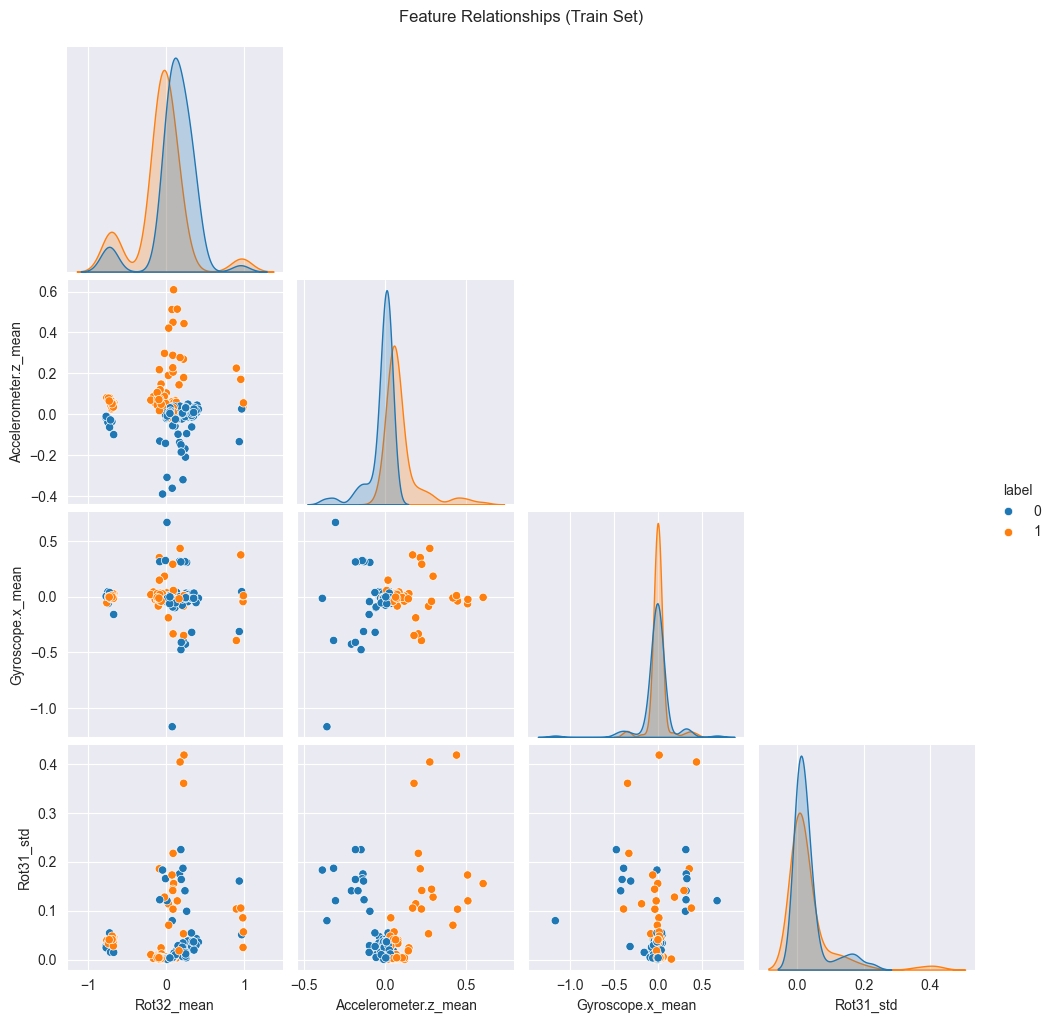

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(
    train,
    vars=["Rot32_mean","Accelerometer.z_mean","Gyroscope.x_mean","Rot31_std"],  # choose key features
    hue="label",
    diag_kind="kde",
    corner=True
)
plt.suptitle("Feature Relationships (Train Set)", y=1.02)
plt.show()


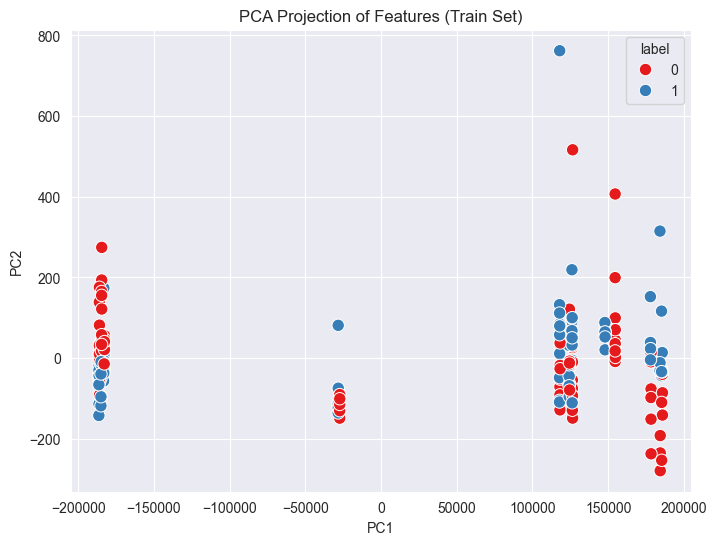

In [127]:

pca = PCA(n_components=2)
proj = pca.fit_transform(train[feature_cols])
plt.figure(figsize=(8,6))
sns.scatterplot(x=proj[:,0], y=proj[:,1], hue=train["label"], palette="Set1", s=80)
plt.title("PCA Projection of Features (Train Set)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Plotting the decision tree

AttributeError: 'XGBClassifier' object has no attribute 'estimators_'

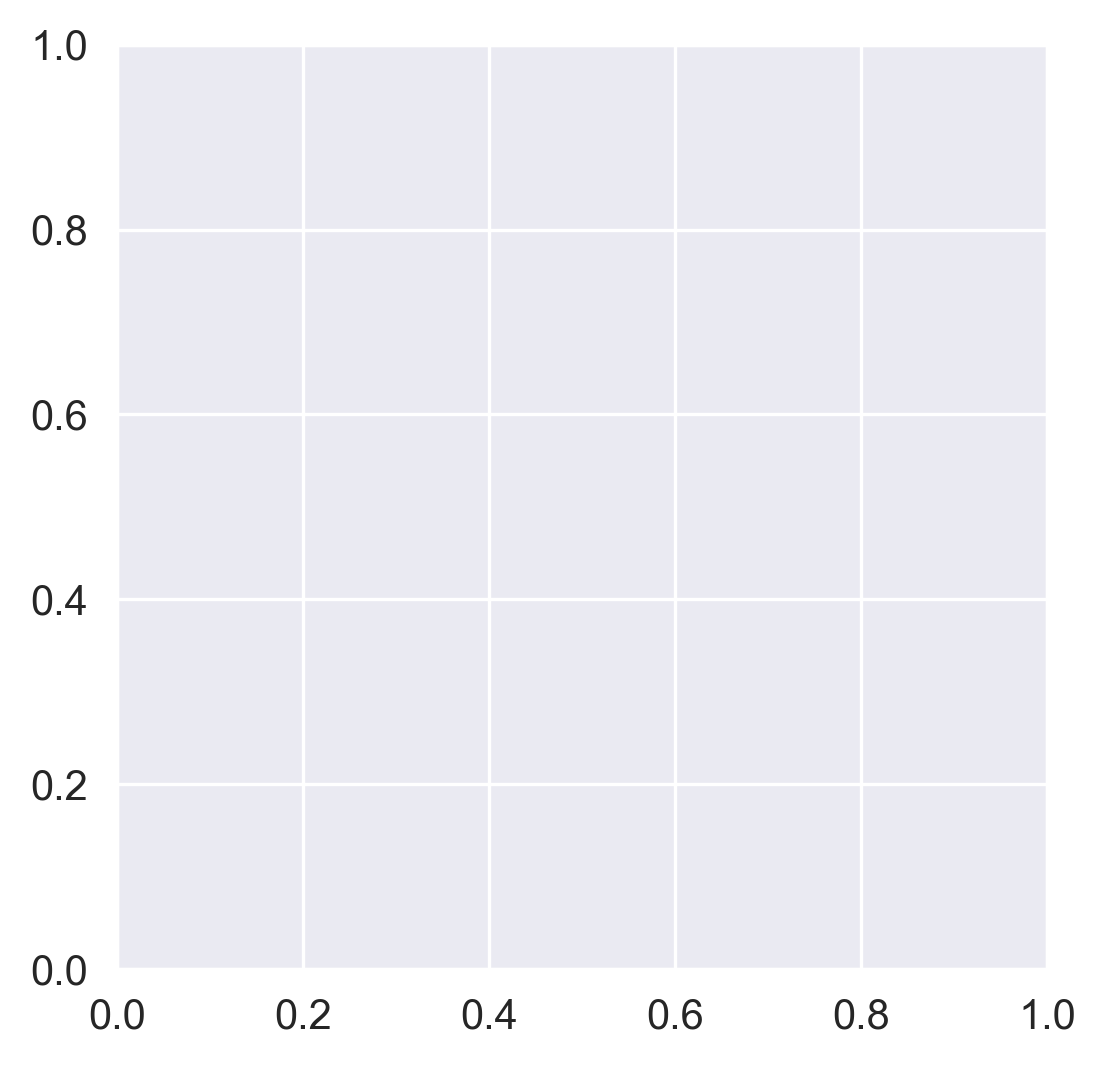

In [128]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf.model.estimators_[0],feature_names=clf.feature_columns, filled=True,rounded=True)
plt.savefig('out/tree.png')